<h1>CS180 MP1</h1>

<h2>Imported libraries</h2>

In [1]:
#Imported libraries
import math
from shapely.geometry import Point, Polygon, LinearRing
from matplotlib import pyplot as plt

<h2>Miscellaneous Functions</h2>

In [2]:
#Functions

#Obtain input file name from user or as a parameter to the function, returns text from entire file, ensure input file is in same directory
def fileInput():
    fileName = input("Input filename: ")
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()
    return fileTxt

#Turns a string of "(x,y)" into a tuple of (x,y)
def textToTuple(text):
    text = text.replace("(","")
    text = text.replace(")","")
    text = text.replace("\n","")
    text = text.split(",")
    # print(text)
    return ((int(text[0]),int(text[1])))

<h1>Input and Parsing</h1>

<p>The Input function takes in the fileTxt and parses it to obtain the Start Position, the Goal Positon and the Polygon vertices.</p>
<p>The function returns an input array of tuples where input[0] is the start position, input[1] is the goal positon, and the remaining entries are arrays of vertices for each polygon</p>

In [3]:
def Input(fileTxt):

    #Divide input text by line
    fileTxt = fileTxt.split('\n')

    #First line is start pos
    startPos = textToTuple(fileTxt.pop(0))

    #Next line is goal pos
    goalPos = textToTuple(fileTxt.pop(0))

    #Remove potential empty lines from of list
    i = 0
    for t in fileTxt:
        if (t == ""):
            fileTxt.pop(i)
        i = i + 1
    
    #Obtain polygon vertices
    polygons = []
    i = 0
    for p in fileTxt:
        p = p.replace("(","")
        p = p.replace(")","")
        p = p.split(",")
        k = 0
        vertices = []
        while(k*2 < len(p)):
            vertices.append((int(p[2*k]),int(p[2*k+1])))
            k = k + 1
        polygons.append(vertices)
        i = i + 1

    #Print inputs
    print("Start Position: " + str(startPos))
    print("Goal Position: " + str(goalPos))
    i = 1
    for p in polygons:
        print("Polygon " + str(i) + " vertices: " + str(p))
        i = i + 1

    inputs = []
    inputs.append(startPos)
    inputs.append(goalPos)
    for p in polygons:
        inputs.append(p)

    return inputs

<h1>Uninformed Search Related Functions</h1>
<p>Functions used in conjunction with BFS and DFS</p>

<h2>initMapUninformed</h2>
<p>initMapUninformed initializes a 100x200 array and sets each value to 0, indicating that all spaces are unvisited</p>

In [4]:
def initMapUninformed(polygons, outlines):
    map = [[] for i in range(101)]

    #List all values for map as 0, meaning they have not been visited yet or -1 if they are inside a polygon
    for i in range (100):
        for j in range(200):
            map[i].append(0)
            p = Point([i,j])
            for polygon in polygons:
                if(p.within(polygon)):
                    map[i][j] = -1
            for outline in outlines:
                if(p.within(outline)):
                    map[i][j] = -1

    return map

<h2>getPathUninformed</h2>
<p>For both the BFS and DFS implementation in this program, each visited node in the 100x200 array is given the position of its parent node, that is, the node that was expanded before the visited node was visited. This function makes use of that to obtain the path. This function starts at the goal position and inspects its value to obtain its parent node, whose position is inserted at the start of the path array. The function then goes to the parent node to obtain the position of the 'grandparent' node and again inserts it into the path array. The function loops this until it arrives at the start node. It then returns the path array.</p>

In [5]:
def getPathUninformed(S,G,map):
    path = []
    path.append(G)
    p = G
    while(path[0] != S):
        p = (map[p[0]][p[1]])
        path.insert(0,p)

    return path

<h1>Uninformed Search Algorithm Implementations</h1>

<h2>Breadth First Search Implementation</h2>

<p>The Breadth First Search implementation in this program expands each node by visiting the nodes to the left, to the right, above, and below the expanded node. This means that the resulting tree has an expansion factor of 4. These visited nodes are then added to the end of the fringe. In order to keep track of the tree, the visited node's corresponding array element is given the value of its parent node's coordinates as a tuple. This also helps indicate that the node is visited, that is, the node's value in the array is != 0</p>

In [6]:
def BFS(S, G, map):
    
    #Initialize fringe
    fringe = [S]
    
    if(G == S):#If start position is goal position, place start position as entry in map
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:#If fringe is empty, algorithm has failed
                break

            #Else, get expand first entry of fringe
            n = fringe.pop(0)
            
            if(n == G): #If dequeued node is G, no need to expand further
                break
            
            #Expand dequeued node into positions above, below, left and right of the expanded node
            down = n[1] + 1
            up = n[1] - 1
            left = n[0] - 1
            right = n[0] + 1

            #If these nodes are valid, insert unvisisted nodes to fringe
            if(left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.append((left,n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 100):
                if(map[right][n[1]] == 0):
                    fringe.append((right,n[1]))
                    map[right][n[1]] = n
            if(up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.append((n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 200):
                if(map[n[0]][down] == 0):
                    fringe.append((n[0],down))
                    map[n[0]][down] = n
    return map

<h2>Depth First Search Implementation</h2>
<p>The depth first search implementation is very similar to the Breadth First Search implementation, with the only difference being the visited nodes are inserted at the start of the fringe instead of at the end.</p>

In [7]:
def DFS(S, G, map):
    #Initialize fringe
    fringe = [S]
    
    
    if(G == S):#Check if current position is goal
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:
                break

            n = fringe.pop(0)

            #Check if dequeued node is G
            if(n == G):
                break
            #Expand dequeued node
            down = n[1] - 1
            up = n[1] + 1
            left = n[0] - 1
            right = n[0] + 1

            #Insert unvisisted nodes to fringe
            if(100 > left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.insert(0,(left, n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 100):
                if(map[right][n[1]] == 0):
                    fringe.insert(0,(right,n[1]))
                    map[right][n[1]] = n
            if(200 > up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.insert(0,(n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 200):
                if(map[n[0]][down] == 0):
                    fringe.insert(0,(n[0],down))
                    map[n[0]][down] = n

    return map

<h1>Testing and Analysis</h1>

<h2>Functions Used for Testing</h2>

<h3>BFS Test Function</h3>

In [8]:
def BFSTest(fileName):
    print("BFS for " + fileName)
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.set_title("BFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.plot(l,w)
        polygons.append(polygon)
        outlines.append(outline)

    map = initMapUninformed(polygons, outlines)

    x = []
    y = []

    for i in range(100):
        for j in range(200):
            if(map[i][j] == -1):
                x.append(i)
                y.append(j)

    ax.plot(x,y, 'o')

    map = BFS(S, G, map)
    path = getPathUninformed(S, G, map)
    #print(path)
    x = []
    y = []
    for p in path:
        x.append(p[0])
        y.append(p[1])
    ax.plot(x,y)

<h3>DFS Test Function</h3>

In [9]:
def DFSTest(fileName):
    print("DFS for " + fileName)
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.set_title("DFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.plot(l,w)
        polygons.append(polygon)
        outlines.append(outline)

    map = initMapUninformed(polygons, outlines)

    x = []
    y = []

    for i in range(100):
        for j in range(200):
            if(map[i][j] == -1):
                x.append(i)
                y.append(j)

    ax.plot(x,y, 'o')

    map = DFS(S, G, map)
    path = getPathUninformed(S, G, map)
    #print(path)
    x = []
    y = []
    for p in path:
        x.append(p[0])
        y.append(p[1])
    ax.plot(x,y)

<h2>Test Cases 1</h2>

BFS for input.txt
Start Position: (2, 4)
Goal Position: (10, 7)
Polygon 1 vertices: [(3, 3), (9, 3), (9, 11), (3, 11)]
Polygon 2 vertices: [(11, 3), (11, 11), (15, 11), (20, 7), (15, 3)]


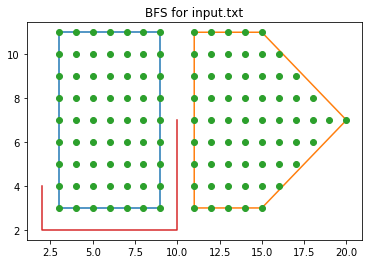

In [10]:
BFSTest("input.txt")

DFS for input.txt
Start Position: (2, 4)
Goal Position: (10, 7)
Polygon 1 vertices: [(3, 3), (9, 3), (9, 11), (3, 11)]
Polygon 2 vertices: [(11, 3), (11, 11), (15, 11), (20, 7), (15, 3)]


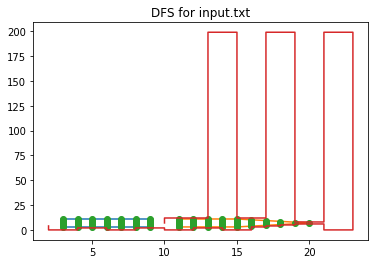

In [11]:
DFSTest("input.txt")